In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df=pd.read_csv('weekly_data.csv')

In [ ]:
df['Month'] = df['Month'].map({
    'January':1,
    'February':2,
    'March':3,
    'April':4,
    'May':5,
    'June':6,
    'July':7,
    'August':8,
    'September':9,
    'October':10,
    'November':11,
    'December':12
})

In [ ]:
df['Week'] = df['Date'].str[-1:]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
df[['Hotel_Revenue','Trends','Flight_Traffic', 'Crime_Rate']]= scaler.fit_transform(df[['Hotel_Revenue','Trends','Flight_Traffic', 'Crime_Rate']])


In [ ]:
df=df.drop(["Date"],axis=1)

In [ ]:
df

,Year,Month,Hotel_Revenue,Trends,Flight_Traffic,Crime_Rate,Week
0,2010,1,-0.293350,0.021655,-0.131650,0.437899,1
1,2010,1,-0.380734,-0.101357,-0.215397,0.262463,2
2,2010,1,-0.738420,-0.604877,-0.558200,-0.455643,3
3,2010,1,-1.410877,-1.551505,-1.202675,-1.805694,4
4,2010,2,-0.788816,-0.343488,-0.473865,-0.138202,1
...,...,...,...,...,...,...,...
619,2022,11,1.527103,1.918082,1.894266,1.314941,4
620,2022,12,-0.558022,-1.003218,-0.530437,-1.588931,1
621,2022,12,0.127531,-0.383961,0.049651,-1.005394,2
622,2022,12,3.878084,3.003896,3.223218,2.187042,3


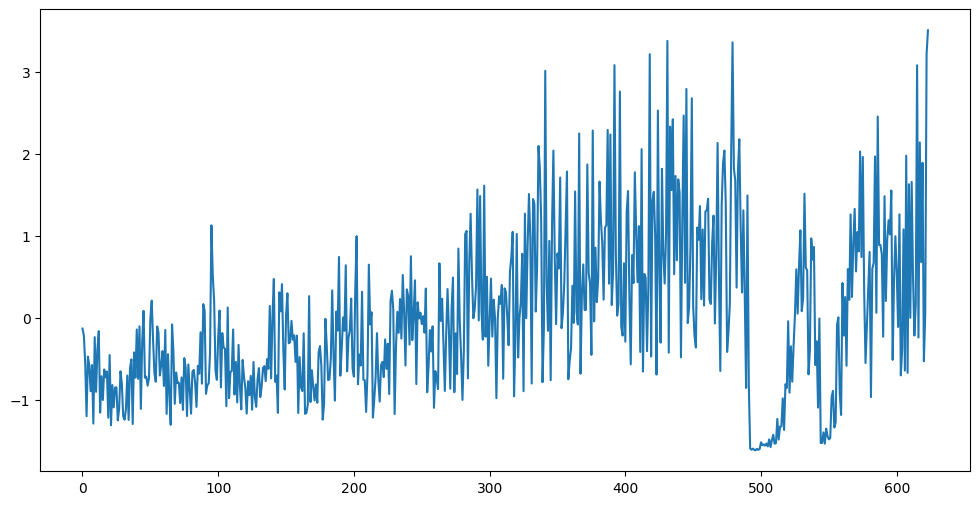

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Flight_Traffic'])
plt.show()

In [ ]:
df['Prev1'] = df['Flight_Traffic'].shift(1)
df['Prev4'] = df['Flight_Traffic'].shift(4)

In [ ]:
df

,Year,Month,Hotel_Revenue,Trends,Flight_Traffic,Crime_Rate,Week,Prev1,Prev4
0,2010,1,-0.293350,0.021655,-0.131650,0.437899,1,NaN,NaN
1,2010,1,-0.380734,-0.101357,-0.215397,0.262463,2,-0.131650,NaN
2,2010,1,-0.738420,-0.604877,-0.558200,-0.455643,3,-0.215397,NaN
3,2010,1,-1.410877,-1.551505,-1.202675,-1.805694,4,-0.558200,NaN
4,2010,2,-0.788816,-0.343488,-0.473865,-0.138202,1,-1.202675,-0.131650
...,...,...,...,...,...,...,...,...,...
619,2022,11,1.527103,1.918082,1.894266,1.314941,4,0.681108,3.085287
620,2022,12,-0.558022,-1.003218,-0.530437,-1.588931,1,1.894266,-0.240884
621,2022,12,0.127531,-0.383961,0.049651,-1.005394,2,-0.530437,2.142593
622,2022,12,3.878084,3.003896,3.223218,2.187042,3,0.049651,0.681108


# Hyperparameter Tuning

The following section contains the process of tuning the hyperparameters of the following algorithms XGBoost, CATBoost and Random Forest

## CATBoost

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split

In [ ]:
X = df[['Hotel_Revenue','Trends','Prev1','Prev4','Crime_Rate','Week','Year','Month']]
y = df['Flight_Traffic']

In [ ]:
cat_features = np.where(X.dtypes != float)[0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 200, 300]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Create a CatBoostRegressor
base_model = CatBoostRegressor(loss_function='RMSE', verbose=0)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Best Parameters: {best_params}")
print(f"Best Mean Squared Error: {mse}")

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import r2_score

# Assuming X_test contains your test features and y_test contains your test labels
y_pred = best_model.predict(X_test)

# Calculate the R2 score
r2 =r2_score(y_test, y_pred)
mse=mean_squared_error(y_test,y_pred)

print(f"R2 Score: {r2}")
print(f"RMSE: {mse**0.5}")

CATBoost shows:
RMSE = 0.15688 and R2 Score= 0.97469

# XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
df['Week']=df['Week'].astype(int)

In [ ]:
X = df[['Hotel_Revenue','Trends','Prev1','Prev4','Crime_Rate','Week','Year','Month']]
y = df['Flight_Traffic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


# Define the parameter grid for Grid Search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9]
}

# Initialize the XGBoost regressor
regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(regressor, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the Grid Search to the training set
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_regressor = grid_search.best_estimator_

# Predict the target variable on the test set using the best model
y_pred = best_regressor.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Best Parameters: {best_params}")

In [ ]:
from sklearn.metrics import r2_score

# Assuming X_test contains your test features and y_test contains your test labels
y_pred = best_regressor.predict(X_test)

# Calculate the R2 score
r2 =r2_score(y_test, y_pred)
mse=mean_squared_error(y_test,y_pred)

print(f"R2 Score: {r2}")
print(f"RMSE: {mse**0.5}")

XGBoost shows: RMSE = 0.16489 and R2 Score= 0.97204


# Random Forest

In [ ]:
df1=df.dropna()

In [ ]:
df1

In [ ]:
X = df1[['Hotel_Revenue','Trends','Prev1','Prev4','Crime_Rate','Week','Year','Month']]
y = df1['Flight_Traffic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Assuming you have your features in X and target variable in y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Regressor
regressor = RandomForestRegressor(random_state=42)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the Grid Search to the training set
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_regressor = grid_search.best_estimator_

# Predict the target variable on the test set using the best model
y_pred = best_regressor.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Best Params: {best_params}")


In [ ]:
print(f"R2 Score: {r2_score(y_test,y_pred)}")

Random Forest shows: RMSE = 0.26191 and R2 Score= 0.91557

# SARIMAX Implementation

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
param_grid={
    'p':[1,2,3],
    'q':[1,2,3],
    'd':[1,2,3]
}

In [ ]:
df

In [ ]:
model = SARIMAX(np.asarray(df['Flight_Traffic']), order=(1,1,1), seasonal_order=(1,1,1,12), exog=None)

In [ ]:
!pip install lazypredict

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

# Split your data into training and test sets (X_train, X_test, y_train, y_test)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models

 21%|██▏       | 9/42 [00:01<00:06,  4.80it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 79%|███████▊  | 33/42 [00:03<00:00, 14.04it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [00:04<00:00, 10.25it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 499, number of used features: 11
[LightGBM] [Info] Start training from score 0.013711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.97,0.97,0.17,0.24
XGBRegressor,0.97,0.97,0.17,0.18
ExtraTreesRegressor,0.96,0.96,0.20,0.76
MLPRegressor,0.95,0.96,0.21,0.55
RandomForestRegressor,0.95,0.95,0.21,0.35
BaggingRegressor,0.95,0.95,0.22,0.16
LGBMRegressor,0.95,0.95,0.22,0.14
NuSVR,0.95,0.95,0.22,0.07
HistGradientBoostingRegressor,0.95,0.95,0.22,0.25


In [ ]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.97,0.97,0.17,0.24
XGBRegressor,0.97,0.97,0.17,0.18
ExtraTreesRegressor,0.96,0.96,0.20,0.76
MLPRegressor,0.95,0.96,0.21,0.55
RandomForestRegressor,0.95,0.95,0.21,0.35
BaggingRegressor,0.95,0.95,0.22,0.16
LGBMRegressor,0.95,0.95,0.22,0.14
NuSVR,0.95,0.95,0.22,0.07
HistGradientBoostingRegressor,0.95,0.95,0.22,0.25
